In [1]:
# pip install kagglehub

In [2]:
import pandas as pd
import numpy as np
import os
import kagglehub
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Download latest version
path = kagglehub.dataset_download("yashdevladdha/uber-ride-analytics-dashboard")

csv_file = path + "/ncr_ride_bookings.csv"

# Load into pandas
df = pd.read_csv(csv_file)

In [4]:
## Data Cleaning and Preprocessing

In [5]:
df.columns

Index(['Date', 'Time', 'Booking ID', 'Booking Status', 'Customer ID',
       'Vehicle Type', 'Pickup Location', 'Drop Location', 'Avg VTAT',
       'Avg CTAT', 'Cancelled Rides by Customer',
       'Reason for cancelling by Customer', 'Cancelled Rides by Driver',
       'Driver Cancellation Reason', 'Incomplete Rides',
       'Incomplete Rides Reason', 'Booking Value', 'Ride Distance',
       'Driver Ratings', 'Customer Rating', 'Payment Method'],
      dtype='object')

#### The code below looks at the columns and skew of the data set. It is important to see if the data set is normally distributed or not to determine how to handle missing values. 

#### Firstly, I need to decide whether or not to ignore any missing values, drop them, or impute them. This will affect my analyses and if I want to run a machine learning model. I will do this by looking at the proportion of missing data per column. If more than 20% of the rows are missing for a column, then I will use mean/median imputation to preserve the size of the data set.

#### Generally speaking, normally distributed variables can use the mean to substitute for missing values. Skewed variables can use the median as this measure is not affected by outliers.

#### I have visualized one of the columns using a histogram plot. As you can see, the data is right-skewed (tail pointed to the right) and will need a median imputation. Below that is a code that shows the skew of each column and the recommended imputation method.

#### Imputation allows for the preservation of the size of the data set instead of dropping rows that are empty.

#### However, some values should not be imputed because it will affect calculations and give inaccurate results. An example of this would be the rating system for drivers and customers, which is on a scale from 1-5. Missing ratings are common and imputing would give an inaccurate representation

In [6]:
df['Cancelled Rides by Driver'].value_counts()

Cancelled Rides by Driver
1.0    27000
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking ID                         150000 non-null  object 
 3   Booking Status                     150000 non-null  object 
 4   Customer ID                        150000 non-null  object 
 5   Vehicle Type                       150000 non-null  object 
 6   Pickup Location                    150000 non-null  object 
 7   Drop Location                      150000 non-null  object 
 8   Avg VTAT                           139500 non-null  float64
 9   Avg CTAT                           102000 non-null  float64
 10  Cancelled Rides by Customer        10500 non-null   float64
 11  Reason for cancelling by Customer  1050

#### Inspect columns to look at unique values

In [8]:
# inspect columns
df['Booking Status'].unique()

array(['No Driver Found', 'Incomplete', 'Completed',
       'Cancelled by Driver', 'Cancelled by Customer'], dtype=object)

In [9]:
df['Vehicle Type'].unique()

array(['eBike', 'Go Sedan', 'Auto', 'Premier Sedan', 'Bike', 'Go Mini',
       'Uber XL'], dtype=object)

In [10]:
# Will replace nan for this column with 'Unknown' instead of dropping nan rows to preserve data size
df['Reason for cancelling by Customer'].unique()

array([nan, 'Driver is not moving towards pickup location',
       'Driver asked to cancel', 'AC is not working', 'Change of plans',
       'Wrong Address'], dtype=object)

In [11]:
df['Cancelled Rides by Driver'].unique()

array([nan,  1.])

In [12]:
# Will replace nan for this column with 'Unknown' instead of dropping nan rows to preserve data size
df['Driver Cancellation Reason'].unique()

array([nan, 'Personal & Car related issues', 'Customer related issue',
       'More than permitted people in there',
       'The customer was coughing/sick'], dtype=object)

In [13]:
# Will replace nan for this column with 'Unknown' instead of dropping nan rows to preserve data size
df['Incomplete Rides Reason'].unique()

array([nan, 'Vehicle Breakdown', 'Other Issue', 'Customer Demand'],
      dtype=object)

In [14]:
df['Driver Ratings'].unique()

array([nan, 4.9, 4.6, 4.1, 4. , 4.4, 4.2, 4.7, 3.8, 5. , 3.7, 3.1, 4.5,
       3.9, 4.3, 3.3, 3.2, 4.8, 3.6, 3.5, 3.4, 3. ])

In [15]:
# replace nan with "Unknown" to preserve size of data set
df['Payment Method'].unique()

array([nan, 'UPI', 'Debit Card', 'Cash', 'Uber Wallet', 'Credit Card'],
      dtype=object)

In [16]:
df['Cancelled Rides by Customer'].unique()

array([nan,  1.])

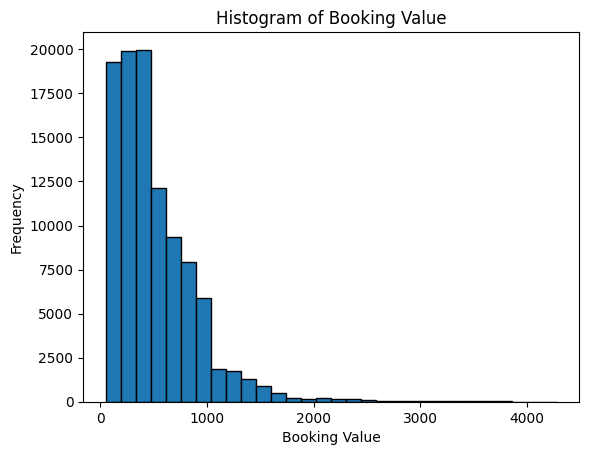

In [17]:
## check distribution of data
plt.hist(df['Booking Value'], bins=30, edgecolor='k')
plt.title('Histogram of Booking Value')
plt.xlabel('Booking Value')
plt.ylabel('Frequency')
plt.show()

#### The code below selects columns with numeric data types and checks the skew. 
#### These are the columns that I am looking to impute either by mean/median imputation. 
#### 0.5 threshold is a commonly used threshold to measure skew.
#### Any categorical/object data type, I will usually fill with "Unknown" or something similar to preserve the size of the data set.

In [18]:
numeric_cols = df.select_dtypes(include=np.number).columns
skew_info = {}

for col in numeric_cols:
    skewness = df[col].skew()
    skew_info[col] = skewness
    if abs(skewness) > 0.5:
        method = 'median'  # Use median if skewed
    else:
        method = 'mean'    # Use mean if approximately symmetric
    print(f"Column: {col}, Skewness: {skewness:.2f}, Suggested fill method: {method}")

# Optional: create a DataFrame summary
skew_df = pd.DataFrame({
    'Column': skew_info.keys(),
    'Skewness': skew_info.values()
})
skew_df

Column: Avg VTAT, Skewness: 0.31, Suggested fill method: mean
Column: Avg CTAT, Skewness: 0.05, Suggested fill method: mean
Column: Cancelled Rides by Customer, Skewness: 0.00, Suggested fill method: mean
Column: Cancelled Rides by Driver, Skewness: 0.00, Suggested fill method: mean
Column: Incomplete Rides, Skewness: 0.00, Suggested fill method: mean
Column: Booking Value, Skewness: 2.29, Suggested fill method: median
Column: Ride Distance, Skewness: 0.13, Suggested fill method: mean
Column: Driver Ratings, Skewness: -0.66, Suggested fill method: median
Column: Customer Rating, Skewness: -0.89, Suggested fill method: median


,Column,Skewness
0,Avg VTAT,0.306565
1,Avg CTAT,0.045900
2,Cancelled Rides by Customer,0.000000
3,Cancelled Rides by Driver,0.000000
4,Incomplete Rides,0.000000
5,Booking Value,2.287351
6,Ride Distance,0.128312
7,Driver Ratings,-0.655715
8,Customer Rating,-0.885531


#### Calculate percentage of missing data

In [19]:
# Percentage of missing values per column
missing_percent = df.isna().mean() * 100

print(missing_percent)

Date                                  0.0
Time                                  0.0
Booking ID                            0.0
Booking Status                        0.0
Customer ID                           0.0
Vehicle Type                          0.0
Pickup Location                       0.0
Drop Location                         0.0
Avg VTAT                              7.0
Avg CTAT                             32.0
Cancelled Rides by Customer          93.0
Reason for cancelling by Customer    93.0
Cancelled Rides by Driver            82.0
Driver Cancellation Reason           82.0
Incomplete Rides                     94.0
Incomplete Rides Reason              94.0
Booking Value                        32.0
Ride Distance                        32.0
Driver Ratings                       38.0
Customer Rating                      38.0
Payment Method                       32.0
dtype: float64


#### Looking at the information above, it makes sense to use imputation because more than 20% of the rows for the numerical columns are missing. 
#### I am using mean/median imputation because the columns have a skew and seem random.

In [20]:
# replace nan values with "Unknown"
df['Incomplete Rides Reason'] = df['Incomplete Rides Reason'].fillna('Reason Unkown')
df['Driver Cancellation Reason'] = df['Driver Cancellation Reason'].fillna('Reason Unkown')
df['Reason for cancelling by Customer'] = df['Reason for cancelling by Customer'].fillna('Reason Unkown')
# fill missing values with 0 to indicate rides that were not cancelled
df['Incomplete Rides'] = df['Incomplete Rides'].fillna(0) 
df['Cancelled Rides by Customer'] = df['Cancelled Rides by Customer'].fillna(0)
df['Cancelled Rides by Driver'] = df['Cancelled Rides by Driver'].fillna(0)
#Impute using mean/median
df['Avg VTAT'].fillna(df['Avg VTAT'].mean(), inplace=True)
df['Avg CTAT'].fillna(df['Avg CTAT'].mean(), inplace=True)
df['Booking Value'].fillna(df['Booking Value'].median(), inplace=True)
df['Ride Distance'].fillna(df['Ride Distance'].mean(), inplace=True)
# I am not going to impute the ratings at risk of creating bias in the data set. Also this might not be random

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking ID                         150000 non-null  object 
 3   Booking Status                     150000 non-null  object 
 4   Customer ID                        150000 non-null  object 
 5   Vehicle Type                       150000 non-null  object 
 6   Pickup Location                    150000 non-null  object 
 7   Drop Location                      150000 non-null  object 
 8   Avg VTAT                           150000 non-null  float64
 9   Avg CTAT                           150000 non-null  float64
 10  Cancelled Rides by Customer        150000 non-null  float64
 11  Reason for cancelling by Customer  1500

In [22]:
df = df.iloc[:, :21]

In [23]:
# I am separating the data set with the ratings into a different data set for now. 
df2 = df.drop(['Driver Ratings', 'Customer Rating'], axis=1)

### Exploratory Analysis

In [24]:
# convert time data to time of day
df2['Time'] = pd.to_datetime(df2['Time'], format='%H:%M:%S').dt.time
df2['Hour'] = pd.to_datetime(df2['Time'], format='%H:%M:%S').dt.hour

# function to calculate time of day
def getTimeofDay(Hour):
    if Hour >=6 and Hour <=12:
        return 'Morning'
    elif Hour>12 and Hour<=18:
        return 'Afternoon'
    elif Hour >18 and Hour<=24:
        return 'Evening'
    elif Hour >=0 and Hour <6:
        return 'Late Night'

df2['TimeofDay'] = df2['Hour'].apply(getTimeofDay)

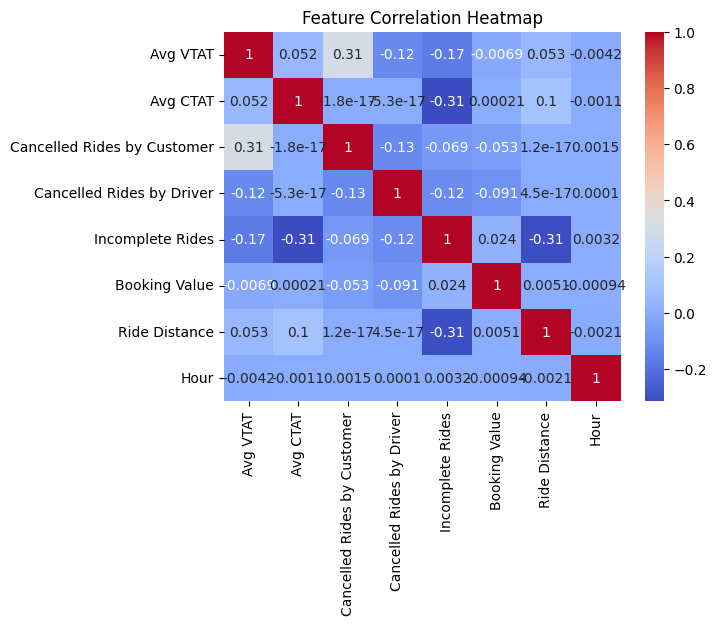

In [25]:
# create heatmap to look at correlation between columns

sns.heatmap(df2.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

#### Looking at the correlation heatmap above, we can see that one of the strongest correlations is between:
#### -incomplete rides and average CTAT (average trip duration from pickup to drop off)
#### -ride distance and incomplete rides

#### There is a relatively strong correlation between Avg VTAT (average time to pickup) and cancelled rides by customers.

#### This makes sense given that customers are more likely to cancel their rides if it takes too long to pick up. Also if the ride is incomplete, then the average duration of the trip should be negatively correlated as seen in the heat map.

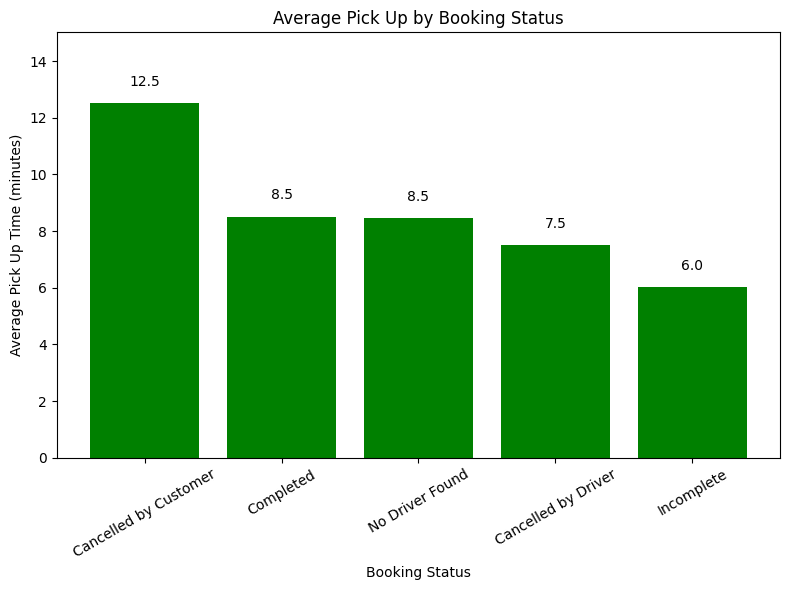

In [26]:
# Scatter plot of average VTAT (time to pickup) and booking status
avg_vtat = df2.groupby('Booking Status')['Avg VTAT'].mean().sort_values(ascending=False)

# Bar plot
plt.figure(figsize=(8,6))
bars = plt.bar(avg_vtat.index, avg_vtat.values, color='green')

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.1f}', 
             ha='center', va='bottom')

plt.xlabel('Booking Status')
plt.ylabel('Average Pick Up Time (minutes)')
plt.title('Average Pick Up by Booking Status')
plt.xticks(rotation=30)
plt.ylim(0, max(avg_vtat.values) * 1.2)  # 20% extra space above the tallest bar
plt.tight_layout()
plt.show()

#### Considering the relatively strong correlation between Avg VTAT (time for the driver to reach the pick up location) and cancellation by customer, I have created a chart that depicts the average pick up time in minutes (Avg VTAT) and the booking status. As you can see, the difference between a completed booking and a cancellation is approximatley 4 minutes.

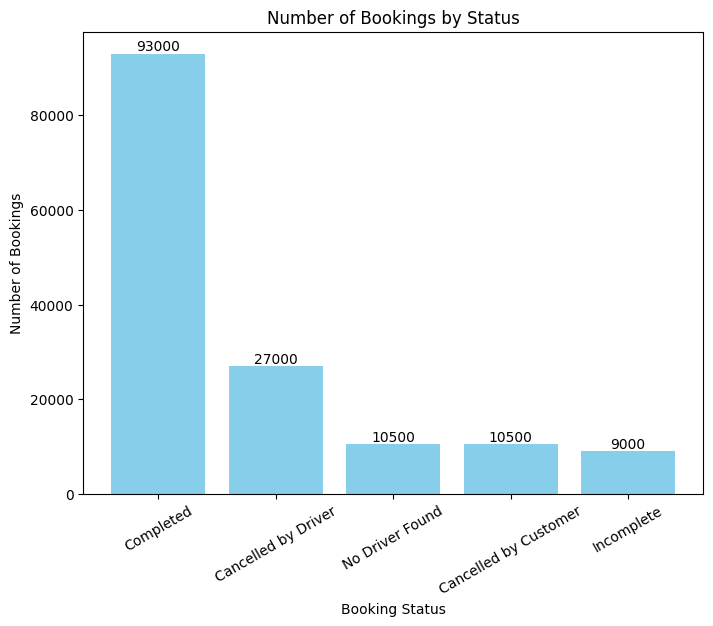

In [27]:
# Plot Booking Status

status_counts = df2['Booking Status'].value_counts()

# Bar plot
plt.figure(figsize=(8,6))
bars = plt.bar(status_counts.index, status_counts.values, color='skyblue')

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, str(height),
             ha='center', va='bottom')

plt.xlabel('Booking Status')
plt.ylabel('Number of Bookings')
plt.title('Number of Bookings by Status')
plt.xticks(rotation=30)
plt.show()

#### Looking at the breakdown of booking status, you can see that there are approximately 9000 incomplete bookings. Most of the bookings are completed and the second most common status is a cancellation by the driver.

In [28]:
# Count bookings for several specific reasons
# Filter rows where Incomplete Rides == 1
incomplete_df = df2[df2['Incomplete Rides'] == 1]

# Count the reasons within that filtered data
reason_counts = incomplete_df['Incomplete Rides Reason'].value_counts()

print(reason_counts)


Incomplete Rides Reason
Customer Demand      3040
Vehicle Breakdown    3012
Other Issue          2948
Name: count, dtype: int64


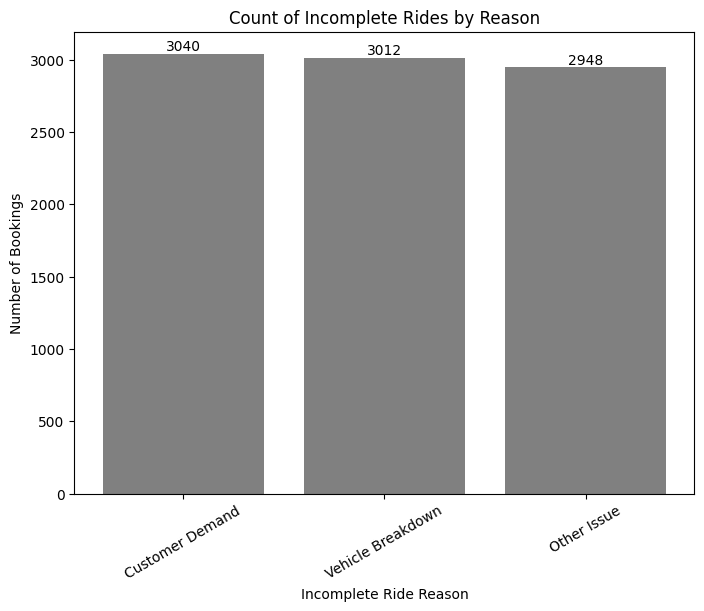

In [29]:
# Now plot the count of each incomplete rides reason
plt.figure(figsize=(8,6))
bars = plt.bar(reason_counts.index, reason_counts.values, color='gray')

# Add labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, str(height),
             ha='center', va='bottom')

plt.xlabel('Incomplete Ride Reason')
plt.ylabel('Number of Bookings')
plt.title('Count of Incomplete Rides by Reason')
plt.xticks(rotation=30)
plt.show()

#### Looking at the breakdown of incomplete ride reasons, out of the 9000 incomplete statuses, most were by customer demand, then vehicle breakdown, and then other issues. Something to look into is the difference between customer demand and customer cancellation, which is a separate booking status.

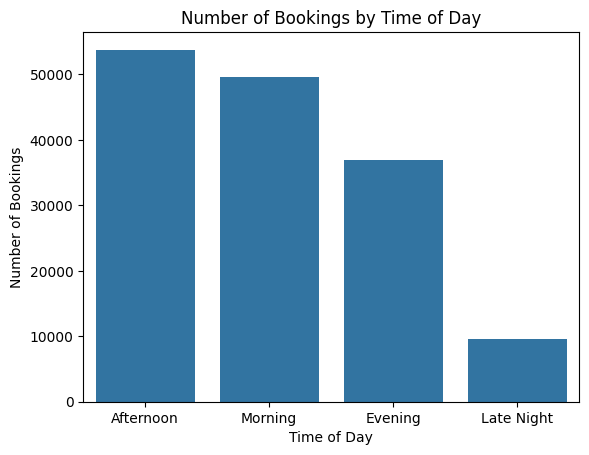

In [30]:
# Number of bookings by time of day
sns.countplot(x='TimeofDay', data=df2, order=df2['TimeofDay'].value_counts().index)
plt.title("Number of Bookings by Time of Day")
plt.ylabel("Number of Bookings")
plt.xlabel("Time of Day")
plt.show()

#### Looking at the time of day and number of bookings, afternoons have the highest number of bookings and late nights have the fewest.

#### In summary, a couple of suggestions is to focus increase driver availability during the afternoons when bookings are most popular and to have drivers take no longer than 8.5 minutes to get to the pickup location.

### Machine Learning

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
df = df2

In [33]:
df.columns

Index(['Date', 'Time', 'Booking ID', 'Booking Status', 'Customer ID',
       'Vehicle Type', 'Pickup Location', 'Drop Location', 'Avg VTAT',
       'Avg CTAT', 'Cancelled Rides by Customer',
       'Reason for cancelling by Customer', 'Cancelled Rides by Driver',
       'Driver Cancellation Reason', 'Incomplete Rides',
       'Incomplete Rides Reason', 'Booking Value', 'Ride Distance',
       'Payment Method', 'Hour', 'TimeofDay'],
      dtype='object')

In [34]:
label_encoders = {}
for col in df.columns:
    if df[col].dtype == 'object' or isinstance(df[col].iloc[0], str):
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# Define features & target
leak_columns = ['Reason for cancelling by Customer', 'Driver Cancellation Reason','Incomplete Rides Reason']  # add more if needed
target_col = "Booking Status"
X = df.drop(columns=leak_columns + [target_col])
y = df[target_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#### I split the data set first and specifically stratified the data set because most of the bookings are 'Completed'. Then I scaled it to avoid feature leakage.

In [37]:
# Initialize models
models = {
    # "Logistic Regression": LogisticRegression(max_iter=1000, solver = 'saga'),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=5, n_jobs=-1, random_state=42),
    "Naive Bayes": GaussianNB(),
#     "SVM": SVC(),
#     "KNN": KNeighborsClassifier()
}


try:
    from xgboost import XGBClassifier
    models["XGBoost"] = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
except ImportError:
    print("XGBoost not installed, skipping...")

# Train & evaluate
accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds) * 100
    accuracies[name] = round(acc, 2)


results_df = pd.DataFrame(list(accuracies.items()), columns=["Model", "Accuracy (%)"])
print(results_df)

C:\Users\grace\anaconda3\envs\my_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:05:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


           Model  Accuracy (%)
0  Decision Tree        100.00
1  Random Forest        100.00
2    Naive Bayes         92.32
3        XGBoost        100.00


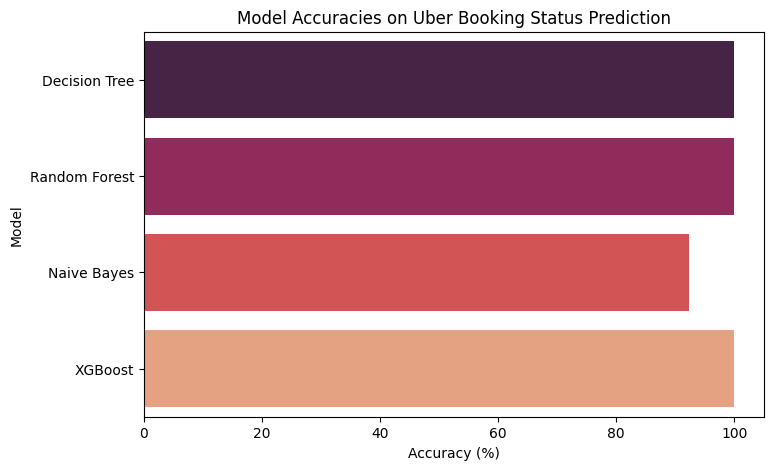

In [38]:
# Plot bar chart
plt.figure(figsize=(8,5))
sns.barplot(x="Accuracy (%)", y="Model", data=results_df, hue = 'Model', legend = False, palette="rocket")
plt.title("Model Accuracies on Uber Booking Status Prediction")
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")
plt.show()

#### The accuracy of the models are extremely high. This was due to most of the bookings being "Completed" and the other columns being related to the booking status feature leakage). I handled this by stratifying my data set, splitting my dataset before scaling, and removing features that may be related to the target column. I was also running into issues with the Logistic Regression because of the size of the dataset.I removed the SVM and KNN models and reduced the depth of the decision trees to avoid overfitting. Unfortunately, the models still showed an almost perfect score which means there are too many 'Completed' booking statuses. Recommendations are to reduce the size of the data set and experiment with the proportions although the trade off of this is that it may not accurately reflect real-life scenarios.

In [42]:
print(f"\n--- {name} ---")
print("Classification Report:")
print(classification_report(y_test, preds))  # precision, recall, F1-score
print("Confusion Matrix:")
print(confusion_matrix(y_test, preds))


--- XGBoost ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2100
           1       1.00      1.00      1.00      5400
           2       1.00      1.00      1.00     18600
           3       1.00      1.00      1.00      1800
           4       1.00      1.00      1.00      2100

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000

Confusion Matrix:
[[ 2100     0     0     0     0]
 [    0  5400     0     0     0]
 [    0     0 18600     0     0]
 [    0     0     0  1800     0]
 [    0     0     0     0  2100]]
